# 常见的爬虫场景1：

先是通过索引页获取详情页list链接地址，再到获取的链接地址页面 获取需要的内容

In [ ]:
#transcript-9c1b02b9-fa7a-41e4-a943-c1376cba8e64 > div:nth-child(1) > div:nth-child(2) > div:nth-child(1)

https://baike.baidu.com/wikitag/taglist?tagId=75953
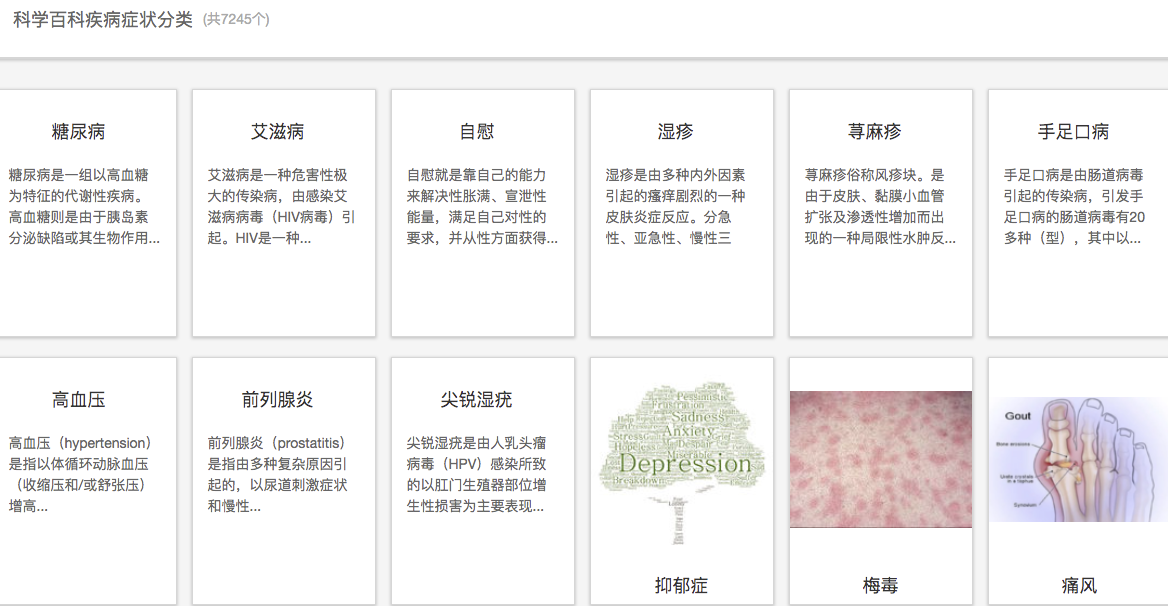

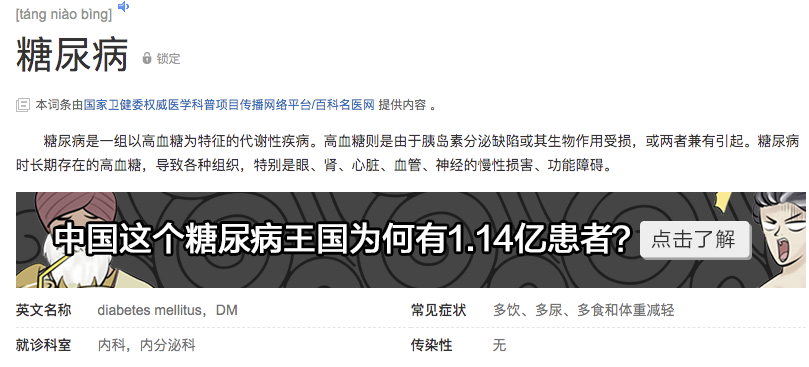

## 流程示例
https://www.jianshu.com/writer#/notebooks/23191721/notes/21395615

为了防止爬到一半被封IP，每一步都要落盘

一般情况下，index_urls数量较少，可以不落盘

通过解析得到detail_urls数量较多，这一步要先落盘，同时要记录爬取的位置。

为了验证爬取的结果是否正确，最好把url和要爬取的内容一并记录到DB中

### get_page_index拿到索引页面的链接请求

In [ ]:
from urllib.parse import urlencode
import requests
from requests import RequestException
def get_page_index(offset, keyword):
    data = {
        'autoload': 'true',
        'count': 20,
        'cur_tab': 3,
        'format': 'json',
        'keyword': keyword,
        'offset': offset,
        'from':'gallery'
    }
    params = urlencode(data)
    base = 'http://www.toutiao.com/search_content/'
    url = base + '?' + params
    try:
        response = requests.get(url)
        if response.status_code == 200:
            return(response.text)
        return None
    except RequestException:
        print('Error occurred')
        return None

if __name__ == '__main__':
    get_page_index(0, '街拍')

### parse_page_index解析索引页面，获取详情url列表

In [ ]:
def parse_page_index(text):
    try:
        data = json.loads(text)
        if data and 'data' in data.keys():
            for item in data.get('data'):
                yield item.get('article_url')
    except JSONDecodeError:
        pass
if __name__ == '__main__':
    text = get_page_index(0, '街拍')
    for url in parse_page_index(text):
        print(url)

http://toutiao.com/group/6501560950192079374/
http://toutiao.com/group/6501588485487460878/
http://toutiao.com/group/6501627692767511054/

### get_page_detail拿到详情url对应的页面数据

In [ ]:
def get_page_detail(url):
    try:
        response = requests.get(url)
        if response.status_code == 200:
            return response.text
        return None
    except ConnectionError:
        print('Error occurred')
        return None
if __name__ == '__main__':
    text = get_page_index(0, '街拍')
    for url in parse_page_index(text):
        print(get_page_detail(url))

### parse_page_detail解析子页面，获取相应数据，存储DB

In [ ]:
def download_image(url):
    print('Downloading', url)
    try:
        response = requests.get(url)
        if response.status_code == 200:
            save_image(response.content)
        return None
    except ConnectionError:
        return None
def save_image(content):
    file_path = '{0}/{1}.{2}'.format(os.getcwd(), md5(content).hexdigest(), 'jpg')
    print(file_path)
    if not os.path.exists(file_path):
        with open(file_path, 'wb') as f:
            f.write(content)
            f.close()
def parse_page_detail(html, url):
    soup = BeautifulSoup(html, 'html.parser')
    result = soup.find('title')
    title = result.get_text() if result else ''
    images_pattern = re.compile(r'gallery: JSON.parse\("(.*?)"\),', re.S)
    result = re.search(images_pattern, html)
    if result:
        data = json.loads(re.sub(r'\\','',result.group(1)))
        if data and 'sub_images' in data.keys():
            sub_images = data.get('sub_images')
            images = [item.get('url') for item in sub_images]
            for image in images: download_image(image)
            return {
                'title': title,
                'url': url,
                'images': images
            }

### 添加多线程支持

In [ ]:
from multiprocessing import Pool

def main(offset):
    print(offset)


if __name__ == '__main__':
    pool = Pool(3)
    groups = ([x * 5 for x in range(1, 14)])
    print(groups)
    pool.map(main, groups)
    pool.close()
    pool.join()
[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65]
5
10
15
20
25
30
35
40
45
50
55
60
65

# 示例1
https://www.jianshu.com/writer#/notebooks/23191721/notes/21395615